In [3]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 2.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Energy function by HoG

In [2]:
def compute_energy_hog(image, params):
    """
    Compute the energy of the image using Histogram of Oriented Gradients (HoG).
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.abs(dx) + np.abs(dy)
    
    # Extract HoG parameters from dictionary
    cell_size = params['cell_size']
    block_size = params['block_size']
    stride = params['stride']
    nbins = params['nbins']
    
    # Compute HoG with configurable parameters
    hog = cv2.HOGDescriptor(
        _winSize=(gray.shape[1] // cell_size[1] * cell_size[1], gray.shape[0] // cell_size[0] * cell_size[0]),
        _blockSize=block_size,
        _blockStride=stride,
        _cellSize=cell_size,
        _nbins=nbins
    )
    hog_features = hog.compute(gray).reshape(-1, nbins)

    # Map HoG features back to the energy map size
    energy_map = np.zeros_like(gradient_magnitude, dtype=np.float64)
    for i in range(0, gray.shape[0] - cell_size[0] + 1, cell_size[0]):
        for j in range(0, gray.shape[1] - cell_size[1] + 1, cell_size[1]):
            idx = (i // cell_size[0]) * (gray.shape[1] // cell_size[1]) + (j // cell_size[1])
            energy_map[i:i + cell_size[0], j:j + cell_size[1]] = np.mean(hog_features[idx])

    # Normalize HoG energy to avoid division errors and scale for visualization
    energy_map = np.clip(energy_map, 1e-6, np.percentile(energy_map, 99))  # Clip outliers for stability
    e_hog = gradient_magnitude / energy_map
    e_hog = np.clip(e_hog, 0, np.percentile(e_hog, 99))  # Normalize for visualization
    return e_hog

# Finding the vertical seams 

In [3]:
def find_vertical_seam(energy):
    """
    Find the optimal vertical seam using dynamic programming.
    """
    rows, cols = energy.shape
    seam = np.zeros(rows, dtype=np.int32)
    cost = np.copy(energy)

    for i in range(1, rows):
        for j in range(cols):
            min_cost = cost[i - 1, j]
            if j > 0:
                min_cost = min(min_cost, cost[i - 1, j - 1])
            if j < cols - 1:
                min_cost = min(min_cost, cost[i - 1, j + 1])
            cost[i, j] += min_cost

    # Backtrack to find the seam
    seam[rows - 1] = np.argmin(cost[-1])
    for i in range(rows - 2, -1, -1):
        prev_col = seam[i + 1]
        offset = np.argmin(cost[i, max(0, prev_col - 1):min(cols, prev_col + 2)])
        seam[i] = prev_col + offset - 1 if prev_col > 0 else offset

    return seam

# Step to remove the vertical seam 

In [4]:
def remove_vertical_seam(image, seam):
    """
    Remove the identified vertical seam from the image.
    """
    rows, cols, _ = image.shape
    output = np.zeros((rows, cols - 1, 3), dtype=image.dtype)
    for i in range(rows):
        output[i, :, 0] = np.delete(image[i, :, 0], seam[i])
        output[i, :, 1] = np.delete(image[i, :, 1], seam[i])
        output[i, :, 2] = np.delete(image[i, :, 2], seam[i])
    return output

# Seam Carving

In [5]:
def seam_carve(image, num_seams):
    """
    Seam carving main function to remove vertical seams using eHoG energy.
    """
    for _ in range(num_seams):
        energy = compute_energy_hog(image,params)
        seam = find_vertical_seam(energy)
        image = remove_vertical_seam(image, seam)
    return image

# Load and display the input image

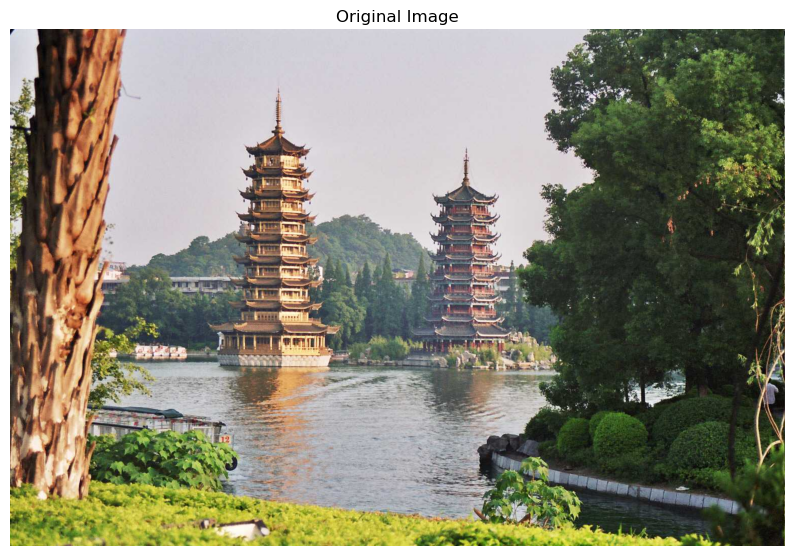

In [6]:
input_image = cv2.imread('img/guilin.jpg') 
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Display the original image
plt.figure(figsize=(10, 10))
plt.title("Original Image")
plt.imshow(input_image)
plt.axis("off")
plt.show()

In [7]:
original_width = input_image.shape[1]
print(f"Original Width: {original_width}")

Original Width: 1536


Step 1: Define parameters

In [8]:
params = {
    'cell_size': (4, 4),
    'block_size': (8, 8),
    'stride': (4, 4),
    'nbins': 9
}

Step 2: Compute and show the energy map of the test image

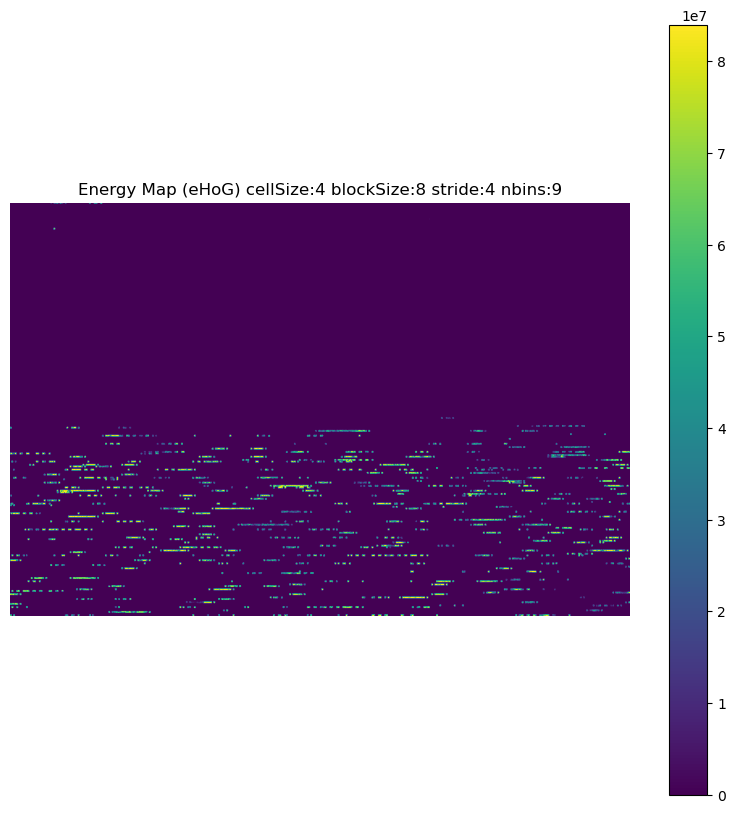

In [9]:
energy_map = compute_energy_hog(
    input_image,
    params
)

# Display the energy map
plt.figure(figsize=(10, 10))
plt.title("Energy Map (eHoG) cellSize:4 blockSize:8 stride:4 nbins:9")
plt.imshow(energy_map)
plt.colorbar()
plt.axis("off")
plt.show()

Step 3: Perform seam carving

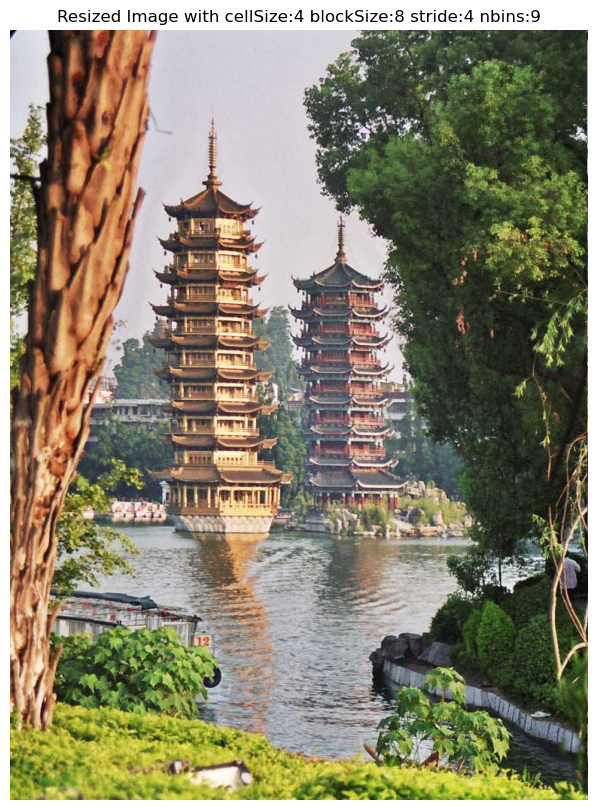

In [10]:
num_seams_to_remove = int(input_image.shape[1] / 2)
output_image = seam_carve(input_image, num_seams_to_remove)

# Display the output image
plt.figure(figsize=(10, 10))
plt.title("Resized Image with cellSize:4 blockSize:8 stride:4 nbins:9")
plt.imshow(output_image)
plt.axis("off")
plt.show()

In [11]:
original_width = input_image.shape[1]
output_width = output_image.shape[1]
print(f"Original Width: {original_width}, Resized Width: {output_width}")

Original Width: 1536, Resized Width: 768


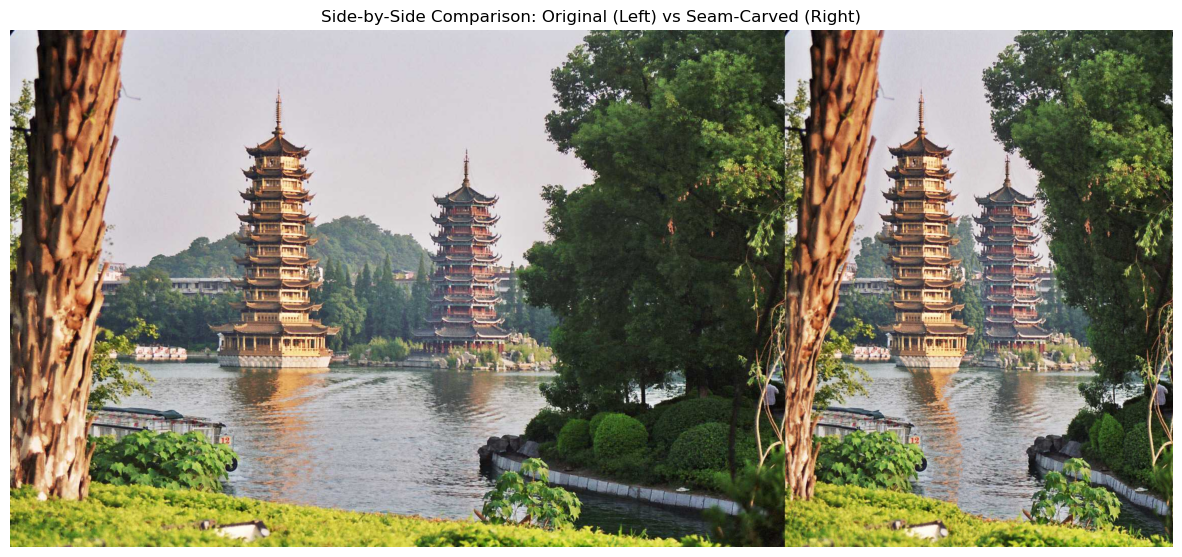

In [12]:
# Create a side-by-side comparison of the original resized image and the seam-carved result
comparison_image = np.hstack((input_image, output_image))

# Display the side-by-side comparison
plt.figure(figsize=(15, 10))
plt.title("Side-by-Side Comparison: Original (Left) vs Seam-Carved (Right)")
plt.imshow(comparison_image)
plt.axis("off")
plt.show()
